In [1]:
#!pip install scikit-learn

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
data_train = pd.read_csv('../data_cleaned/data_train.csv')
item_categories = pd.read_csv('../data_cleaned/item_categories.csv')
items = pd.read_csv('../data_cleaned/items.csv')
shops = pd.read_csv('../data_cleaned/shops.csv')

In [3]:
#merged = data_train.merge(items, how='left').merge(item_categories, how='left').merge(shops, how='left')

In [4]:
def parse_city(shop_name):
    if shop_name.split()[0] == '!Якутск':
        return  'Якутск'

    if shop_name.split()[0] == 'Сергиев':
            return  'Сергиев Посад'
    else:
        return shop_name.split()[0]

In [5]:
#dates = pd.to_datetime(data_train['date'], format='%d.%m.%Y')


In [6]:
grouped=data_train.groupby(['shop_id','item_id','date_block_num']).agg({'item_price':'mean',
                                                                    'item_cnt_day':'sum'
                                                                    })#take some (a lot)))) ) time

In [7]:
grouped

item_price  item_cnt_day
shop_id item_id date_block_num                          
2       27      0                   2499.0           1.0
                17                   498.0           1.0
        30      2                    359.0           1.0
                5                    399.0           1.0
                15                   169.0           1.0
...                                    ...           ...
59      22164   27                   699.0           2.0
                30                   699.0           1.0
        22167   9                    299.0           1.0
                11                   299.0           2.0
                17                   299.0           1.0

[1608225 rows x 2 columns]

In [8]:
grouped=grouped.reset_index().sort_values(by='date_block_num').reset_index(drop=True)

In [9]:
grouped

,shop_id,item_id,date_block_num,item_price,item_cnt_day
0,2,484,0,300.0,2.0
1,59,22151,0,399.0,2.0
2,2,482,0,3300.0,1.0
3,59,22154,0,999.0,1.0
4,35,2934,0,599.0,1.0
...,...,...,...,...,...
1608220,31,16451,33,249.0,2.0
1608221,57,1545,33,5998.0,1.0
1608222,57,1540,33,1999.0,1.0
1608223,57,1539,33,1199.0,3.0


In [10]:
merged = grouped.merge(items, how='left').merge(item_categories, how='left').merge(shops, how='left')

In [11]:
merged.isna().sum()

shop_id               0
item_id               0
date_block_num        0
item_price            0
item_cnt_day          0
item_name             0
item_category_id      0
item_category_name    0
shop_name             0
dtype: int64

In [12]:
import calendar

def number_to_month(numbers):
    # Create a list of month names using the calendar module
    month_names = list(calendar.month_name)[1:]  # Extract months from 1 to 12 (exclude the empty element at index 0)
    
    # Convert the numbers to month names
    result = [month_names[num % 12] for num in numbers]  # Use num % 12 to handle numbers beyond 11
    
    return result


In [13]:

def number_to_month(numbers):
    result = [num %12 for num in numbers]  # Use num % 12 to handle numbers beyond 11
    
    return result


In [14]:
def convert_to_year(month_num):
    # January 2013 is the starting point
    start_year = 2013
    
    # Calculate the year
    year = start_year + (month_num // 12)
    
    return year

In [15]:
merged['month'] = number_to_month(merged['date_block_num'])
merged['year'] = merged['date_block_num'].apply(convert_to_year)

In [16]:
merged['super_category'] = merged['item_category_name'].apply(lambda a: a.split()[0])

In [17]:

merged['city'] = merged['shop_name'].apply(parse_city)

In [18]:
#merged = merged.drop(['shop_id','item_id','item_category_id'],axis=1)

In [19]:
merged=merged.rename(columns={'item_price':'avg_item_price','item_cnt_day':'item_cnt_month'})

In [20]:
item_lags=list([*range(1,6),11,12])
price_lags=list([*range(1,6),11,12])

In [21]:

def create_lags(data,item_lags=None,price_lags=None):
    lagged_items = data[['date_block_num','item_cnt_month','shop_id','item_id']].copy()
    for lag in item_lags:
        #print(lagged_items['date_block_num'].iloc[1000000])
        lagged_items['date_block_num']+=lag#previous month becomes present
        #print(lagged_items['date_block_num'].iloc[1000000])
        data=data.merge(lagged_items, how='left',on=['date_block_num','shop_id','item_id'], suffixes=('', f'_lag_{lag}'))
        #print(data)
        lagged_items['date_block_num']-=lag

    lagged_prices = data[['date_block_num','avg_item_price','shop_id','item_id']].copy()
    for lag in price_lags:
        lagged_prices['date_block_num']+=lag#previous month becomes present
        data=data.merge(lagged_prices, how='left',on=['date_block_num','shop_id','item_id'], suffixes=('', f'_lag_{lag}'))
        lagged_prices['date_block_num']-=lag

        
    return data

In [22]:
merged['item_cnt_month'] = merged['item_cnt_month'].fillna(0)

In [23]:
lagged = create_lags(merged,item_lags=item_lags,price_lags=price_lags)#takes a bit time

In [24]:
#lagged = lagged.drop(['avg_item_price'],axis=1)#we can't use it for train
lagged['shop_id_cat'] = lagged['shop_id'].astype('str')
lagged['item_id_cat'] = lagged['item_id'].astype('str')
lagged['item_category_id_cat'] = lagged['item_category_id'].astype('str')
#lagged = lagged.drop(['shop_id','item_id','item_name','shop_name','item_category_id','item_category_name'],axis=1)


In [25]:
df = merged

In [26]:
def avg(data):
    v = data['item_cnt_month'].mode().mean()

    return v#.mode()[0]#.mean()

In [27]:
def avg_by_city(data, city):
    v = data [data['city']==city] ['item_cnt_month'].mode().mean()
    
    return v# .mode()[0]

In [28]:
def avg_by_shop(data, shop):
    v = data [data['shop_id']==shop] ['item_cnt_month'].mode().mean()
    
    return v# .mode()[0]#.mean()

In [29]:
#df.groupby('item_category_id')['date_block_num'].transform('min')

In [30]:

# 1. Create the 'first_date_block_num' column (first appearance of each item_id)
df['first_date_block_num'] = df.groupby('item_id')['date_block_num'].transform('min')

# 2. Create the 'first_cat_block_num' column (first appearance of each item_category_id)
df['first_cat_block_num'] = df.groupby('item_category_id')['date_block_num'].transform('min')
df['first_sup_cat_block_num'] = df.groupby('super_category')['date_block_num'].transform('min')

# Display the DataFrame with the new columns
df[['item_id', 'item_category_id', 'date_block_num', 'first_date_block_num', 'first_cat_block_num']]

,item_id,item_category_id,date_block_num,first_date_block_num,first_cat_block_num
0,484,73,0,0,0
1,22151,40,0,0,0
2,482,73,0,0,0
3,22154,37,0,0,0
4,2934,21,0,0,0
...,...,...,...,...,...
1608220,16451,37,33,0,0
1608221,1545,20,33,27,10
1608222,1540,20,33,31,10
1608223,1539,30,33,28,0


In [31]:

# 1. Create the 'first_date_block_num' column (first appearance of each item_id)
lagged['first_date_block_num'] = lagged.groupby('item_id')['date_block_num'].transform('min')
lagged['date_block_num_diff'] = lagged['date_block_num'] - lagged['first_date_block_num']

# 2. Create the 'first_cat_block_num' column (first appearance of each item_category_id)
lagged['first_cat_block_num'] = lagged.groupby('item_category_id')['date_block_num'].transform('min')
lagged['first_sup_cat_block_num'] = lagged.groupby('super_category')['date_block_num'].transform('min')

# Display the DataFrame with the new columns
lagged[['item_id', 'item_category_id', 'date_block_num', 'first_date_block_num', 'first_cat_block_num']]

,item_id,item_category_id,date_block_num,first_date_block_num,first_cat_block_num
0,484,73,0,0,0
1,22151,40,0,0,0
2,482,73,0,0,0
3,22154,37,0,0,0
4,2934,21,0,0,0
...,...,...,...,...,...
1608220,16451,37,33,0,0
1608221,1545,20,33,27,10
1608222,1540,20,33,31,10
1608223,1539,30,33,28,0


In [32]:

def create_lags_columns(data, columns,item_lags=[1,2,3],price_lags=[1,2,3]):
    
    lagged_items = data[[*columns,'item_cnt_month']]
    
    for lag in item_lags:
        lagged_items.loc[:,'date_block_num']+=lag#previous month becomes present

        averaged = lagged_items.groupby(columns).mean().reset_index()
        
        data=data.merge(averaged, how='left',on=columns, suffixes=('', f'{'_'.join(columns[1:])}_lag_{lag}'))
        
        lagged_items.loc[:,'date_block_num']-=lag

    lagged_prices = data[[*columns,'avg_item_price']]
    for lag in price_lags:
        lagged_prices.loc[:,'date_block_num']+=lag#previous month becomes present

        averaged = lagged_prices.groupby(columns).mean().reset_index()
        
        data=data.merge(averaged, how='left',on=columns, suffixes=('', f'{'_'.join(columns[1:])}_lag_{lag}'))
        lagged_prices.loc[:,'date_block_num']-=lag

        
    return data

In [33]:
#import warnings
#warnings.simplefilter(action='ignore', category=FutureWarning)

In [34]:
lagged = create_lags_columns(lagged,columns=['date_block_num','shop_id','item_category_name'] )

In [35]:
lagged = create_lags_columns(lagged,columns=['date_block_num','super_category'] )

In [36]:
lagged = create_lags_columns(lagged,columns=['date_block_num','item_id'] )

In [37]:
lagged = create_lags_columns(lagged,columns=['date_block_num','item_category_name'] )

In [38]:
lagged = create_lags_columns(lagged,columns=['date_block_num','city'] )

In [39]:
target = 'item_cnt_month'
group_col='city'
min_periods=3
lag_data = lagged[[f'{target}{group_col}_lag_1', f'{target}{group_col}_lag_2', f'{target}{group_col}_lag_3']]
ema_series = lag_data.ewm(alpha=0.5, min_periods=min_periods, axis=1)

/tmp/ipykernel_4424/2877779004.py:5: FutureWarning: Support for axis=1 in DataFrame.ewm is deprecated and will be removed in a future version. Use obj.T.ewm(...) instead
  ema_series = lag_data.ewm(alpha=0.5, min_periods=min_periods, axis=1)


In [40]:
rm = ema_series.mean()

In [40]:
import pandas as pd

# Assuming your DataFrame is named 'df'

# Function to calculate EMA over the lag columns
#@numba.jit(, parallel = True, nogil = True) 
def calculate_ema_3(df, min_periods=3, target='item_cnt_month', columns=None, test_included=False):#pass date_block_num as a first colummn
    # Create a temporary dataframe with the 3 lags
    
    def calculate_ema(df,group_col):#na not ignored
        #print(df.head())
        alpha=0.7
        
        lag_data = df.iloc[0][[f'{target}{'_'.join(group_col[1:])}_lag_1', f'{target}{'_'.join(group_col[1:])}_lag_2', f'{target}{'_'.join(group_col[1:])}_lag_3']]
        lag_data=lag_data.fillna(0)
        
        weights = (1 - alpha) ** np.arange(3)
        
        weighted_sum = (lag_data * weights).sum()
        
        weights[lag_data==0]=0
        
        weight_sum = weights.sum()
        if weight_sum == 0:
            return np.nan
            
        results=weighted_sum/weight_sum
        
        return results

    #print(columns)
    calcs=df.groupby(columns).apply(lambda group: calculate_ema(group, columns),include_groups=False).reset_index(name =f'ema_{target}_{'_'.join(columns[1:])}')
    #print(calcs)
    
    df = pd.merge(df, calcs, on=columns, how='left')
    return df


In [41]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [71]:
lagged = calculate_ema_3(lagged, target='item_cnt_month',columns=['date_block_num','shop_id','item_category_name'])#takes time(most - ema by shop_id item_id, VERY long)#if one of 3 lags exist than not none

In [43]:
lagged = calculate_ema_3(lagged, target='item_cnt_month',columns=['date_block_num','super_category'])#takes time(most - ema by shop_id item_id, VERY long)(dont count here))))

In [44]:
lagged = calculate_ema_3(lagged, target='item_cnt_month',columns=['date_block_num','item_id'])#takes time(most - ema by shop_id item_id, VERY long)(dont count here))))

In [45]:
lagged = calculate_ema_3(lagged, target='item_cnt_month',columns=['date_block_num','item_category_name'])#takes time(most - ema by shop_id item_id, VERY long)(dont count here))))

In [46]:
print(lagged['ema_item_cnt_month_super_category'].isna().sum())
print(lagged['item_cnt_monthsuper_category_lag_3'].isna().sum())

63212
187264


In [47]:
s = set(set(lagged[lagged['ema_item_cnt_month_super_category'].isna()].index) - set(lagged[lagged['avg_item_pricesuper_category_lag_3'].isna()].index) )
s

set()

In [48]:
lagged.iloc[241377].ema_item_cnt_month_super_category

np.float64(1.0)

In [49]:
lagged.iloc[241377].ema_item_cnt_month_super_category

np.float64(1.0)

In [50]:
lagged.columns

Index(['shop_id', 'item_id', 'date_block_num', 'avg_item_price',
       'item_cnt_month', 'item_name', 'item_category_id', 'item_category_name',
       'shop_name', 'month', 'year', 'super_category', 'city',
       'item_cnt_month_lag_1', 'item_cnt_month_lag_2', 'item_cnt_month_lag_3',
       'item_cnt_month_lag_4', 'item_cnt_month_lag_5', 'item_cnt_month_lag_11',
       'item_cnt_month_lag_12', 'avg_item_price_lag_1', 'avg_item_price_lag_2',
       'avg_item_price_lag_3', 'avg_item_price_lag_4', 'avg_item_price_lag_5',
       'avg_item_price_lag_11', 'avg_item_price_lag_12', 'shop_id_cat',
       'item_id_cat', 'item_category_id_cat', 'first_date_block_num',
       'date_block_num_diff', 'first_cat_block_num', 'first_sup_cat_block_num',
       'item_cnt_monthshop_id_item_category_name_lag_1',
       'item_cnt_monthshop_id_item_category_name_lag_2',
       'item_cnt_monthshop_id_item_category_name_lag_3',
       'avg_item_priceshop_id_item_category_name_lag_1',
       'avg_item_pricesh

In [51]:
lagged[lagged['item_id'] == 13345]

,shop_id,item_id,date_block_num,avg_item_price,item_cnt_month,item_name,item_category_id,item_category_name,shop_name,month,...,item_cnt_monthcity_lag_1,item_cnt_monthcity_lag_2,item_cnt_monthcity_lag_3,avg_item_pricecity_lag_1,avg_item_pricecity_lag_2,avg_item_pricecity_lag_3,ema_avg_item_price_shop_id_item_category_name,ema_item_cnt_month_super_category,ema_item_cnt_month_item_id,ema_item_cnt_month_item_category_name
113,30,13345,0,25.0,3.0,Компактдиск Mirex CD-R 700 Мб 52x Slim case MA...,82,Чистые носители (штучные),"Москва ТЦ ""Перловский""",0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5984,16,13345,0,25.0,9.0,Компактдиск Mirex CD-R 700 Мб 52x Slim case MA...,82,Чистые носители (штучные),"Коломна ТЦ ""Рио""",0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7934,54,13345,0,25.0,17.0,Компактдиск Mirex CD-R 700 Мб 52x Slim case MA...,82,Чистые носители (штучные),"Химки ТЦ ""Мега""",0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8464,51,13345,0,13.0,74.0,Компактдиск Mirex CD-R 700 Мб 52x Slim case MA...,82,Чистые носители (штучные),"Тюмень ТЦ ""Зеленый Берег""",0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10802,2,13345,0,25.0,5.0,Компактдиск Mirex CD-R 700 Мб 52x Slim case MA...,82,Чистые носители (штучные),"Адыгея ТЦ ""Мега""",0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
833142,44,13345,14,25.0,48.0,Компактдиск Mirex CD-R 700 Мб 52x Slim case MA...,82,Чистые носители (штучные),"Самара ТЦ ""Мелодия""",2,...,1.795639,1.641084,2.046501,688.035063,679.815975,750.279658,37.500000,15.553048,39.919424,20.063440
842881,44,13345,15,25.0,70.0,Компактдиск Mirex CD-R 700 Мб 52x Slim case MA...,82,Чистые носители (штучные),"Самара ТЦ ""Мелодия""",3,...,1.831995,1.795639,1.641084,715.940704,688.035063,679.815975,40.497602,14.198470,29.705036,17.578212
922619,44,13345,16,25.0,12.0,Компактдиск Mirex CD-R 700 Мб 52x Slim case MA...,82,Чистые носители (штучные),"Самара ТЦ ""Мелодия""",4,...,1.717193,1.831995,1.795639,723.654569,715.940704,688.035063,31.205036,17.922234,58.863309,27.682288
1092498,11,13345,20,13.0,1.0,Компактдиск Mirex CD-R 700 Мб 52x Slim case MA...,82,Чистые носители (штучные),Жуковский ул. Чкалова 39м²,8,...,1.556627,1.447028,1.541555,682.207229,715.062016,730.554960,NaN,3.769231,NaN,3.769231


In [129]:
first_month = 5
chosen = df[ df['item_id'].isin( df[df['first_date_block_num'] == first_month]['item_id'])]#choose elemnents that were first time sold in 10 month
ch_gr = chosen.groupby('date_block_num').agg({'item_cnt_month':'mean','avg_item_price':'mean'}).reset_index()
plt.plot(ch_gr['date_block_num'], ch_gr['item_cnt_month'])#use EMA may be good idea

NameError: name 'plt' is not defined

In [ ]:
#df_without_first_3 = df[~df['date_block_num'].isin([0,1,2]) ]

In [52]:
first_index_block_3 = df[df['date_block_num'] == 3 ].index[0]

In [53]:
first_index_block_3

np.int64(187032)

In [54]:
#df_without_first_3=df_without_first_3.drop('index',axis=1)
#df=df.drop('index',axis=1)

In [55]:
df

,shop_id,item_id,date_block_num,avg_item_price,item_cnt_month,item_name,item_category_id,item_category_name,shop_name,month,year,super_category,city,first_date_block_num,first_cat_block_num,first_sup_cat_block_num
0,2,484,0,300.0,2.0,1С:Бухгалтерия 8. Учебная версия. Издание 6.,73,Программы - 1С:Предприятие 8,"Адыгея ТЦ ""Мега""",0,2013,Программы,Адыгея,0,0,0
1,59,22151,0,399.0,2.0,ЯВЛЕНИЕ (2012),40,Кино - DVD,"Ярославль ТЦ ""Альтаир""",0,2013,Кино,Ярославль,0,0,0
2,2,482,0,3300.0,1.0,1С:Бухгалтерия 8. Базовая версия,73,Программы - 1С:Предприятие 8,"Адыгея ТЦ ""Мега""",0,2013,Программы,Адыгея,0,0,0
3,59,22154,0,999.0,1.0,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,"Ярославль ТЦ ""Альтаир""",0,2013,Кино,Ярославль,0,0,0
4,35,2934,0,599.0,1.0,"Disney. Миссия Дарвина (Essentials) [PSP, русс...",21,Игры - PSP,"Н.Новгород ТРЦ ""Фантастика""",0,2013,Игры,Н.Новгород,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1608220,31,16451,33,249.0,2.0,ОБЛАЧНЫЙ АТЛАС (BD),37,Кино - Blu-Ray,"Москва ТЦ ""Семеновский""",9,2015,Кино,Москва,0,0,0
1608221,57,1545,33,5998.0,1.0,Assassin's Creed: Единство. Guillotine Edition...,20,Игры - PS4,"Якутск Орджоникидзе, 56",9,2015,Игры,Якутск,27,10,0
1608222,57,1540,33,1999.0,1.0,"Assassin's Creed: Единство [PS4, русская версия]",20,Игры - PS4,"Якутск Орджоникидзе, 56",9,2015,Игры,Якутск,31,10,0
1608223,57,1539,33,1199.0,3.0,"Assassin's Creed: Единство [PC, русская версия]",30,Игры PC - Стандартные издания,"Якутск Орджоникидзе, 56",9,2015,Игры,Якутск,28,0,0


In [56]:
np.sort(df.date_block_num.unique())[1:]

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33])

In [57]:
blocks = [df[df['date_block_num'] == block-1 ].index[-1] for block in np.sort(df.date_block_num.unique())[1:]]

In [58]:
blocks

[np.int64(63169),
 np.int64(123080),
 np.int64(187031),
 np.int64(241621),
 np.int64(294897),
 np.int64(351070),
 np.int64(409074),
 np.int64(467062),
 np.int64(518605),
 np.int64(569662),
 np.int64(621094),
 np.int64(687351),
 np.int64(740621),
 np.int64(788277),
 np.int64(837535),
 np.int64(882254),
 np.int64(927997),
 np.int64(974455),
 np.int64(1020186),
 np.int64(1066604),
 np.int64(1106996),
 np.int64(1149577),
 np.int64(1195318),
 np.int64(1254572),
 np.int64(1301310),
 np.int64(1342670),
 np.int64(1383112),
 np.int64(1415963),
 np.int64(1448169),
 np.int64(1480064),
 np.int64(1513579),
 np.int64(1547051),
 np.int64(1576703)]

In [59]:
def choose_previos_blocks(data_SORTED, idx):
    #idx - idx in data_SORTED
    block = data_SORTED.iloc[idx]['date_block_num']
    last_index_block = blocks[block-1]
    return data_SORTED.iloc[0:last_index_block]

<Axes: >

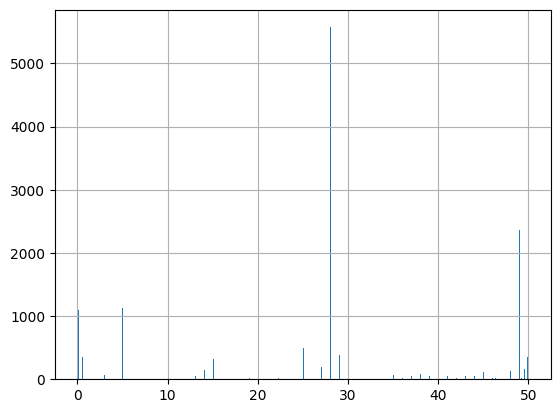

In [60]:
lagged['avg_item_price'].hist(bins=500, range=[0,50])

In [61]:
!pwd

/home/valeriy/python_projects/predict_future_sales/EDA


In [62]:
lagged

,shop_id,item_id,date_block_num,avg_item_price,item_cnt_month,item_name,item_category_id,item_category_name,shop_name,month,...,item_cnt_monthcity_lag_1,item_cnt_monthcity_lag_2,item_cnt_monthcity_lag_3,avg_item_pricecity_lag_1,avg_item_pricecity_lag_2,avg_item_pricecity_lag_3,ema_avg_item_price_shop_id_item_category_name,ema_item_cnt_month_super_category,ema_item_cnt_month_item_id,ema_item_cnt_month_item_category_name
0,2,484,0,300.0,2.0,1С:Бухгалтерия 8. Учебная версия. Издание 6.,73,Программы - 1С:Предприятие 8,"Адыгея ТЦ ""Мега""",0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,59,22151,0,399.0,2.0,ЯВЛЕНИЕ (2012),40,Кино - DVD,"Ярославль ТЦ ""Альтаир""",0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,482,0,3300.0,1.0,1С:Бухгалтерия 8. Базовая версия,73,Программы - 1С:Предприятие 8,"Адыгея ТЦ ""Мега""",0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,59,22154,0,999.0,1.0,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,"Ярославль ТЦ ""Альтаир""",0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,35,2934,0,599.0,1.0,"Disney. Миссия Дарвина (Essentials) [PSP, русс...",21,Игры - PSP,"Н.Новгород ТРЦ ""Фантастика""",0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1608220,31,16451,33,249.0,2.0,ОБЛАЧНЫЙ АТЛАС (BD),37,Кино - Blu-Ray,"Москва ТЦ ""Семеновский""",9,...,2.682759,2.271802,2.208756,1008.434959,866.729586,887.674964,397.864780,1.547242,NaN,1.508495
1608221,57,1545,33,5998.0,1.0,Assassin's Creed: Единство. Guillotine Edition...,20,Игры - PS4,"Якутск Орджоникидзе, 56",9,...,1.939018,1.919915,1.833333,959.432440,833.283831,806.929796,2392.312978,2.578259,1.359712,3.937857
1608222,57,1540,33,1999.0,1.0,"Assassin's Creed: Единство [PS4, русская версия]",20,Игры - PS4,"Якутск Орджоникидзе, 56",9,...,1.939018,1.919915,1.833333,959.432440,833.283831,806.929796,2392.312978,2.578259,7.057199,3.937857
1608223,57,1539,33,1199.0,3.0,"Assassin's Creed: Единство [PC, русская версия]",30,Игры PC - Стандартные издания,"Якутск Орджоникидзе, 56",9,...,1.939018,1.919915,1.833333,959.432440,833.283831,806.929796,517.799098,2.578259,2.466326,2.643525


In [63]:
import pandas as pd
import numpy as np

# Efficiently calculate the means for rows where date_block_num_diff <= 2 using groupby and cumulative statistics
def calculate_medians_for_diff_leq_2(df):
    # Create placeholders for the 5 columns of means
    df['new_cat_shop_avg'] = np.nan
    df['new_cat_city_avg'] = np.nan
    df['new_cat_avg'] = np.nan
    df['new_sup_cat_city_avg'] = np.nan
    df['sup_cat_avg'] = np.nan

    # Filter rows where date_block_num_diff <= 2
    df_leq_2 = df[df['date_block_num_diff'] <= 2]

    # Precompute groupings based on 'date_block_num'
    for curr_block in df_leq_2['date_block_num'].unique():
        # Consider all rows with date_block_num < curr_block
        prev_blocks = df[df['date_block_num'] < curr_block]

        # Group by the 5 criteria and calculate the means
        cat_shop_avg = prev_blocks.groupby(['item_category_name', 'shop_id'])['item_cnt_month'].mean()
        cat_city_avg = prev_blocks.groupby(['item_category_name', 'city'])['item_cnt_month'].mean()
        cat_avg = prev_blocks.groupby('item_category_name')['item_cnt_month'].mean()
        sup_cat_city_avg = prev_blocks.groupby(['super_category', 'city'])['item_cnt_month'].mean()
        sup_cat_avg = prev_blocks.groupby('super_category')['item_cnt_month'].mean()

        # Assign means back to the rows with current 'date_block_num'
        mask = df['date_block_num'] == curr_block
        df.loc[mask, 'new_cat_shop_avg'] = df[mask].set_index(['item_category_name', 'shop_id']).index.map(cat_shop_avg)
        df.loc[mask, 'new_cat_city_avg'] = df[mask].set_index(['item_category_name', 'city']).index.map(cat_city_avg)
        df.loc[mask, 'new_cat_avg'] = df[mask].set_index('item_category_name').index.map(cat_avg)
        df.loc[mask, 'new_sup_cat_city_avg'] = df[mask].set_index(['super_category', 'city']).index.map(sup_cat_city_avg)
        df.loc[mask, 'sup_cat_avg'] = df[mask].set_index('super_category').index.map(sup_cat_avg)

    return df



In [64]:
lagged = calculate_medians_for_diff_leq_2(lagged)

In [65]:
lagged.to_csv('lagged_final')

In [70]:
lagged['new_cat_shop_avg'].isna().sum()

np.int64(69612)

In [66]:
a=0
b=0
c=0
d=0
e=0
def make_prediction_median(medians):
    new_cat_shop, new_cat_city, new_cat, new_sup_cat_city, sup_cat=medians
    #print(new_cat_shop, new_cat_city, new_cat, new_sup_cat_city, sup_cat)
    if new_cat_shop is not None and not np.isnan(new_cat_shop):
        global a
        a+=1
        #print(new_cat_shop, new_cat_city, new_cat, new_sup_cat_city, sup_cat)
        sales=new_cat_shop
    elif new_cat_city is not None  and not np.isnan(new_cat_city):
        global b
        b+=1
        sales = new_cat_city
    elif new_cat is not None  and not np.isnan(new_cat):
        global c
        c+=1
        sales = new_cat
    elif new_sup_cat_city is not None and not np.isnan(new_sup_cat_city):
        global d
        d+=1
        sales = new_sup_cat_city
    elif sup_cat is not None  and not np.isnan(sup_cat):
        global e
        e+=1
        sales = sup_cat
    #print(sales)
          
    assert (not np.isnan(sales)) and (sales is not None)
    return sales

In [67]:
def predict_EMA(row):
        #skipped (shop_id,item_id)
        #print(row)
        if not np.isnan(row['ema_item_cnt_month_item_id']) and row['ema_item_cnt_month_item_id'] is not None:#predict on item_id
            sales = row['ema_item_cnt_month_item_id']
            
        elif not np.isnan(row['ema_item_cnt_month_shop_id_item_category_name'])  and row['ema_item_cnt_month_shop_id_item_category_name'] is not None:   #predict on category, shop
            sales = row['ema_item_cnt_month_shop_id_item_category_name']
        elif not np.isnan(row['ema_item_cnt_month_item_category_name']):
            #row['ema_item_cnt_month_item_category_name'] is not None:#predict on category
            sales = row['ema_item_cnt_month_item_category_name']#may be nan
        else:
            sales = row['ema_item_cnt_month_super_category']
            assert not np.isnan(sales) and sales is not None, row
        
        assert (not np.isnan(sales) )and (sales is not None)
        return sales

In [81]:
idx_range = [100000,200000]
def manual_preds(data):
    c1=0
    c2=0
    preds = []
    data['date_block_num_diff'] = data['date_block_num'] - data['first_date_block_num']#per ID
    data['cat_diff'] = data['date_block_num'] - data['first_cat_block_num']
    data['super_cat_diff'] = data['date_block_num'] - data['first_sup_cat_block_num']
    #print(data['super_cat_diff'])
    global idx_range
    for idx in range(first_index_block_3+idx_range[0],first_index_block_3+idx_range[1]):
        #sales = None
        row = data.iloc[idx]
        prev = choose_previos_blocks(data,idx)

        #HAVE info for last 3 monthe for item_id(independent from shop)
        sales=predict_EMA(row)
        preds.append(sales)
        """
        if row['date_block_num_diff'] > 2:#can make preds based on EMA (it may be improved with city, super_category)
            c1+=1
            
            sales=predict_EMA(row)#each here have ema by category
        #NO info for last 3 monthes for item_id(independent from shop)
        else:
            c2+=1
            #medians=calculate_median(row,prev)#may be precompute here
            medians = row[['new_cat_shop_avg', 'new_cat_city_avg', 'new_cat_avg', 'new_sup_cat_city_avg', 'sup_cat_avg']]
            sales = make_prediction_median(medians)
            
        assert   not np.isnan(sales) and sales is not None
        preds.append(sales)
        """
    print(c1,c2)
    
    return  preds
    

In [82]:
#lagged = pd.read_csv('lagged_final')

In [83]:
preds = manual_preds(lagged)

0 0


In [84]:
#lagged.iloc[241377]

In [85]:
np.isnan(np.array(preds)).sum()

np.int64(0)

In [86]:
sum(np.array(preds) == 0)

np.int64(0)

In [87]:
#df.iloc[first_index_block_3+7284]

In [88]:
sales_pred_true = pd.DataFrame({ 'pred':preds, 'true':df[first_index_block_3+idx_range[0]:first_index_block_3+idx_range[1]] ['item_cnt_month']})

In [89]:
sales_preds = (sales_pred_true['pred'] - sales_pred_true['true'] ).sort_values()
print(sales_preds)

310959   -693.272849
346469   -690.272849
360063   -640.857457
319797   -628.272849
326747   -561.272849
             ...    
366808    113.142543
365784    120.142543
380927    135.142543
360250    141.142543
378538    152.142543
Length: 100000, dtype: float64


In [90]:
from sklearn.metrics import mean_squared_error

count    100000.000000
mean         -0.050855
std           6.970533
min        -693.272849
25%           0.000000
50%           0.144565
75%           0.509510
max         152.142543
dtype: float64
rmse simple mode().mean() 4.6178528006138375


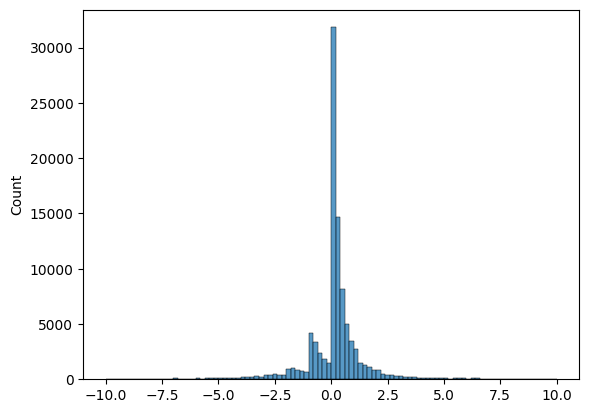

In [91]:
print((sales_pred_true['pred'] - sales_pred_true['true']).describe())
sns.histplot(sales_pred_true['pred'] - sales_pred_true['true'], binrange=[-10,10], bins=100)
print('rmse simple mode().mean()',mean_squared_error(np.clip(sales_pred_true['true'],0,20),np.clip(sales_pred_true['pred'],0,20)))

In [467]:
sales_pred_true['pred'] [(sales_pred_true['pred'] - sales_pred_true['true']) >15]

287948    19.780350
291167    16.026696
291601    26.643064
292486    26.643064
293471    26.643064
            ...    
385735    23.321684
385977    16.774733
386006    16.774733
386172    23.321684
386983    23.321684
Name: pred, Length: 193, dtype: float64

In [468]:
lagged.iloc[187940]

shop_id                         31
item_id                      21376
date_block_num                   3
avg_item_price          398.146078
item_cnt_month               175.0
                           ...    
new_cat_shop_avg          3.082817
new_cat_city_avg          2.338634
new_cat_avg               1.962594
new_sup_cat_city_avg      2.167951
sup_cat_avg               1.837896
Name: 187940, Length: 81, dtype: object

In [469]:
sales_pred_true.iloc[187940- first_index_block_3]

pred    1.114286
true    1.000000
Name: 287940, dtype: float64

In [470]:
lagged[ (lagged['item_category_name'] == 'Кино - DVD') & (lagged['date_block_num'].isin ([0,1,2]) ) ]['item_cnt_month'].describe()

count    51729.000000
mean         1.962594
std          4.095558
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max        169.000000
Name: item_cnt_month, dtype: float64

In [239]:
import matplotlib.pyplot as plt

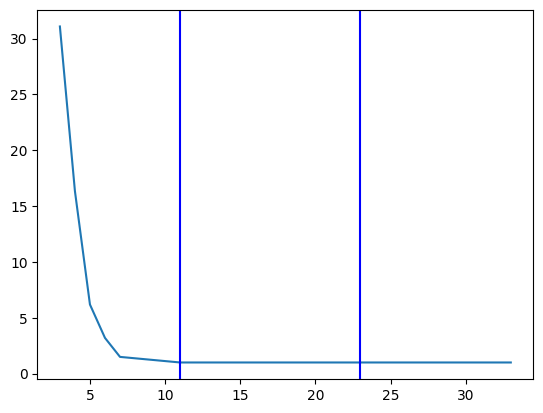

In [240]:
f=lagged[lagged['item_id']== 21376][['item_cnt_month','date_block_num']].groupby('date_block_num').agg({'item_cnt_month':'mean'}).reset_index()
plt.plot(f['date_block_num'], f['item_cnt_month'])
plt.axvline(x = 11, color = 'b', label = 'axvline - full height')
plt.axvline(x = 23, color = 'b', label = 'axvline - full height')

In [197]:
sales_pred_true.iloc[190391 - first_index_block_3]

pred    20.1706
true     1.0000
Name: 190391, dtype: float64

<Axes: ylabel='item_cnt_month'>

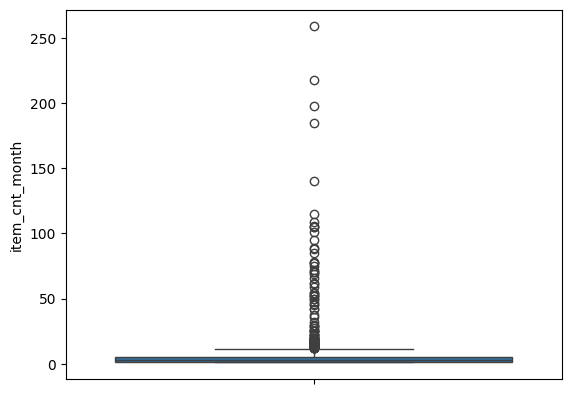

In [101]:
sns.boxplot(df[df['item_id']==	6738]['item_cnt_month'])

In [ ]:
df = merged[merged['item_id']==22045].sort_values(by='date_block_num')[['date_block_num','item_cnt_month']]

In [ ]:
a=df.groupby('date_block_num').agg({'item_cnt_month':'mean'}).reset_index()
plt.plot(a['date_block_num'],a['item_cnt_month'])

In [ ]:
df = merged[merged['item_id']==2244].sort_values(by='date_block_num')[['date_block_num','item_cnt_month']]

In [ ]:
a=df.groupby('date_block_num').agg({'item_cnt_month':'mean'}).reset_index()
plt.plot(a['date_block_num'],a['item_cnt_month'])

In [ ]:
#big errors when item entered data (both for first prediction and few next monthes)
#may be a good idea to delete first 1-3 monthes

In [1]:

preds=manual_preds(lagged, alpha1=0.7, alpha2=1)
rmse: 4.353414981785467

#preds=manual_preds(lagged, alpha1=1, alpha2=1)
#rmse 6.0037769534512515

predict with EMA only (without medinas)
rmse 4.6178528006138375

consider only date_block_num>=3, else too much items appeared first

SyntaxError: invalid syntax (398585007.py, line 5)